# Two-layer custom CNN from MOSAIKS

## Prepare GeoLife data loader

In [1]:
import os
import sys
import time
import inspect
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

random_state = np.random.RandomState(0)

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

# trf = torch.nn.Sequential(
#     transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
#     transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
# )

## Two-layer CNN MOSAIK

In [4]:
kernel_size = '7-7'
mode = 'no_preprocess_no_norm'

model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model(torch.rand((1, 3, 224, 224))).shape

torch.Size([1, 17037])

## Custom Mosaiks

In [5]:
# model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(20736, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, num_species)
#       ) 
# model(torch.rand((1, 3, 224, 224))).shape

## slicing up the network

In [6]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=17037, bias=True)
)

In [7]:
# for 2-conv layers
conv_lyrs = [0, 3]
act_lyrs = [1, 4, 10]

# for 4-conv layers
# conv_lyrs = [0, 2, 4, 6]
# act_lyrs = [1, 4, 7, 10]

In [8]:
for name, param in model.named_parameters():
    print(name, '---------------\t', param.shape)

0.weight ---------------	 torch.Size([64, 3, 7, 7])
0.bias ---------------	 torch.Size([64])
3.weight ---------------	 torch.Size([64, 64, 7, 7])
3.bias ---------------	 torch.Size([64])
9.weight ---------------	 torch.Size([512, 5184])
9.bias ---------------	 torch.Size([512])
11.weight ---------------	 torch.Size([17037, 512])
11.bias ---------------	 torch.Size([17037])


In [9]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same),
 LeakyReLU(negative_slope=0.01),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same),
 LeakyReLU(negative_slope=0.01),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 AdaptiveAvgPool2d(output_size=9),
 Flatten(start_dim=1, end_dim=-1),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=5184, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=17037, bias=True)]

## with hooks

In [10]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [11]:
# model[1], model[4], model[10]

In [12]:
# for 2-conv layers
model[1].register_forward_hook(get_features('relu_layer_1'))
model[4].register_forward_hook(get_features('relu_layer_4'))
model[10].register_forward_hook(get_features('relu_layer_10'))


# for 4-conv layers (without nn.AdaptivePool layer)
# model[1].register_forward_hook(get_features('relu_layer_1'))
# model[4].register_forward_hook(get_features('relu_layer_4'))
# model[7].register_forward_hook(get_features('relu_layer_7'))
# model[10].register_forward_hook(get_features('relu_layer_10'))

In [13]:
conv_lyrs

[0, 3]

In [14]:
all_patches = []
params = []

for layer_idx, relu_idx in enumerate(act_lyrs):
    if layer_idx == len(conv_lyrs):
        break
        
    print(f'for conv layer#{conv_lyrs[layer_idx]}')
    print(f'kmeans for output of relu act layer#{relu_idx}')
    
    curr_param_idx = conv_lyrs[layer_idx]
    curr_param_sz = model[curr_param_idx].weight.data.shape # or list(model.children())[curr_param_idx].weight

    print(f'current parameter size: {curr_param_sz}')
        
    num_feats = curr_param_sz[0]
    num_ch = curr_param_sz[1]
    patch_size = (curr_param_sz[2], curr_param_sz[3])
    num_iters = 6   # The online learning part: cycle over the whole dataset 6 times
    max_patches = int(num_feats/2)

    print(f'num_feats:{num_feats}, num_ch:{num_ch}, patch_size:{patch_size}')
    
    kmeans = MiniBatchKMeans(n_clusters=num_feats, 
                             random_state=random_state,
    #                          max_no_improvement=5,
    #                          tol=0.01,
    #                          max_iter=5,
    #                          batch_size = kmeans_bs,
                             verbose=False)

    geo_train_loader = DataLoader(
                    geo_train_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
#                     pin_memory=True,
                )

    index = 0
    buffer = []

    for _ in range(num_iters):
        for batch in geo_train_loader:
            patches, target, meta = batch

            output = model(patches['rgb'])
        
            if layer_idx == 0:
                curr_feats = patches['rgb'].numpy()
            else:
                curr_feats = features_dim[f'relu_layer_{act_lyrs[layer_idx-1]}'].numpy()
            
            curr_feats = curr_feats.squeeze(0)
            curr_feats = curr_feats.transpose((1,2,0))
#             curr_feats = np.einsum('ijk->jki', curr_feats)

            data = extract_patches_2d(curr_feats, 
                                      patch_size, 
                                      max_patches=max_patches,
                                      random_state=random_state)
#             print(data.shape) # (32, 7, 7, 3) , (32, 7, 7, 64)
            data = np.reshape(data, (len(data), -1))
            all_patches.append(data)
            buffer.append(data)
            index += 1
            if index % int(len(geo_train_loader)/10) == 0:
                data = np.concatenate(buffer, axis=0)
                data -= np.mean(data, axis=0)
                data /= np.std(data, axis=0)
                if np.any(np.isnan(data)):
                    data = np.nan_to_num(data)
                kmeans.partial_fit(data)
                buffer = []
            if index % 10000 == 0:
                print("Partial fit of %4i out of %i" % (index, num_iters * len(geo_train_loader)))

    # change the weights of the corresponding conv layer
    print(f'Updating parameter#{curr_param_idx} with size: {curr_param_sz}')
    params.append(kmeans.cluster_centers_)
    x = torch.from_numpy(kmeans.cluster_centers_.reshape(
                                            num_feats, 
                                            patch_size[0], 
                                            patch_size[1],
                                            num_ch,).transpose(0, 3, 1, 2)
                                        )
    norm_param = (x - x.mean())/(x.std())
    model[curr_param_idx].weight.data = norm_param



    # save the model
    PATH = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_{kernel_size}_{mode}.pt"
    torch.save(model.state_dict(), PATH)


for conv layer#0
kmeans for output of relu act layer#1
current parameter size: torch.Size([64, 3, 7, 7])
num_feats:64, num_ch:3, patch_size:(7, 7)
Partial fit of 10000 out of 12024
Updating parameter#0 with size: torch.Size([64, 3, 7, 7])
for conv layer#3
kmeans for output of relu act layer#4
current parameter size: torch.Size([64, 64, 7, 7])
num_feats:64, num_ch:64, patch_size:(7, 7)
Partial fit of 10000 out of 12024
Updating parameter#3 with size: torch.Size([64, 64, 7, 7])


# Visualize the patches

## directly from the kmeans clusters

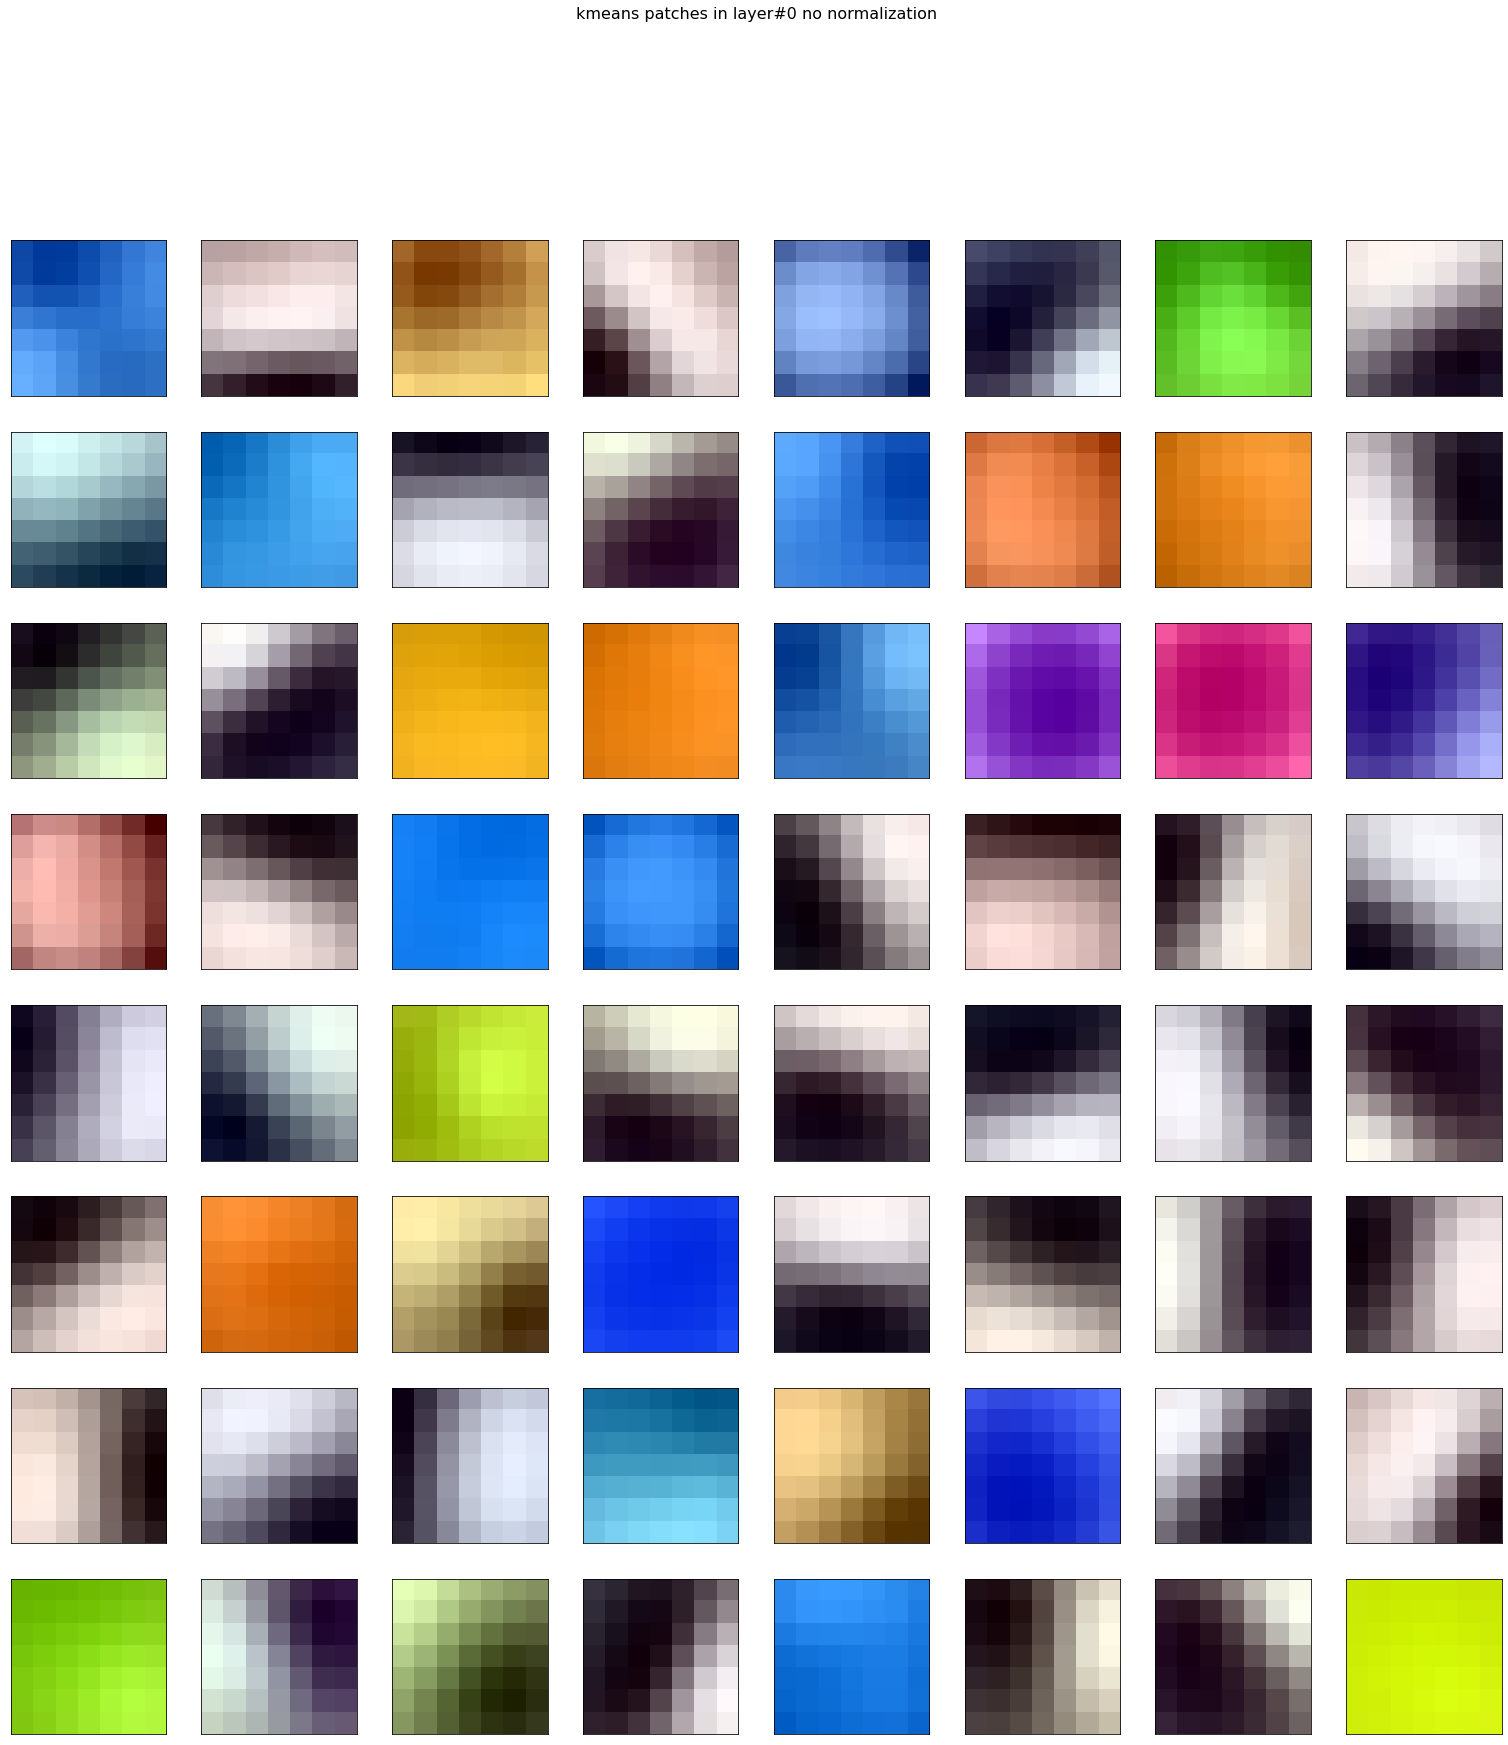

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))
for i, patch in enumerate(params[0]):
    plt.subplot(8, 8, i + 1)
    img = patch.reshape(7, 7, 3) #patch_size[0], patch_size[1]
    img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.xticks(())
    plt.yticks(())

plt.suptitle("kmeans patches in layer#0 no normalization", fontsize=16,)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'patches_0_layer_no_norm.png')

## from the model's weights

In [16]:
first_layer_weights = model[0].weight.data

In [17]:
first_layer_weights.shape

torch.Size([64, 3, 7, 7])

In [18]:
params[0].shape

(64, 147)

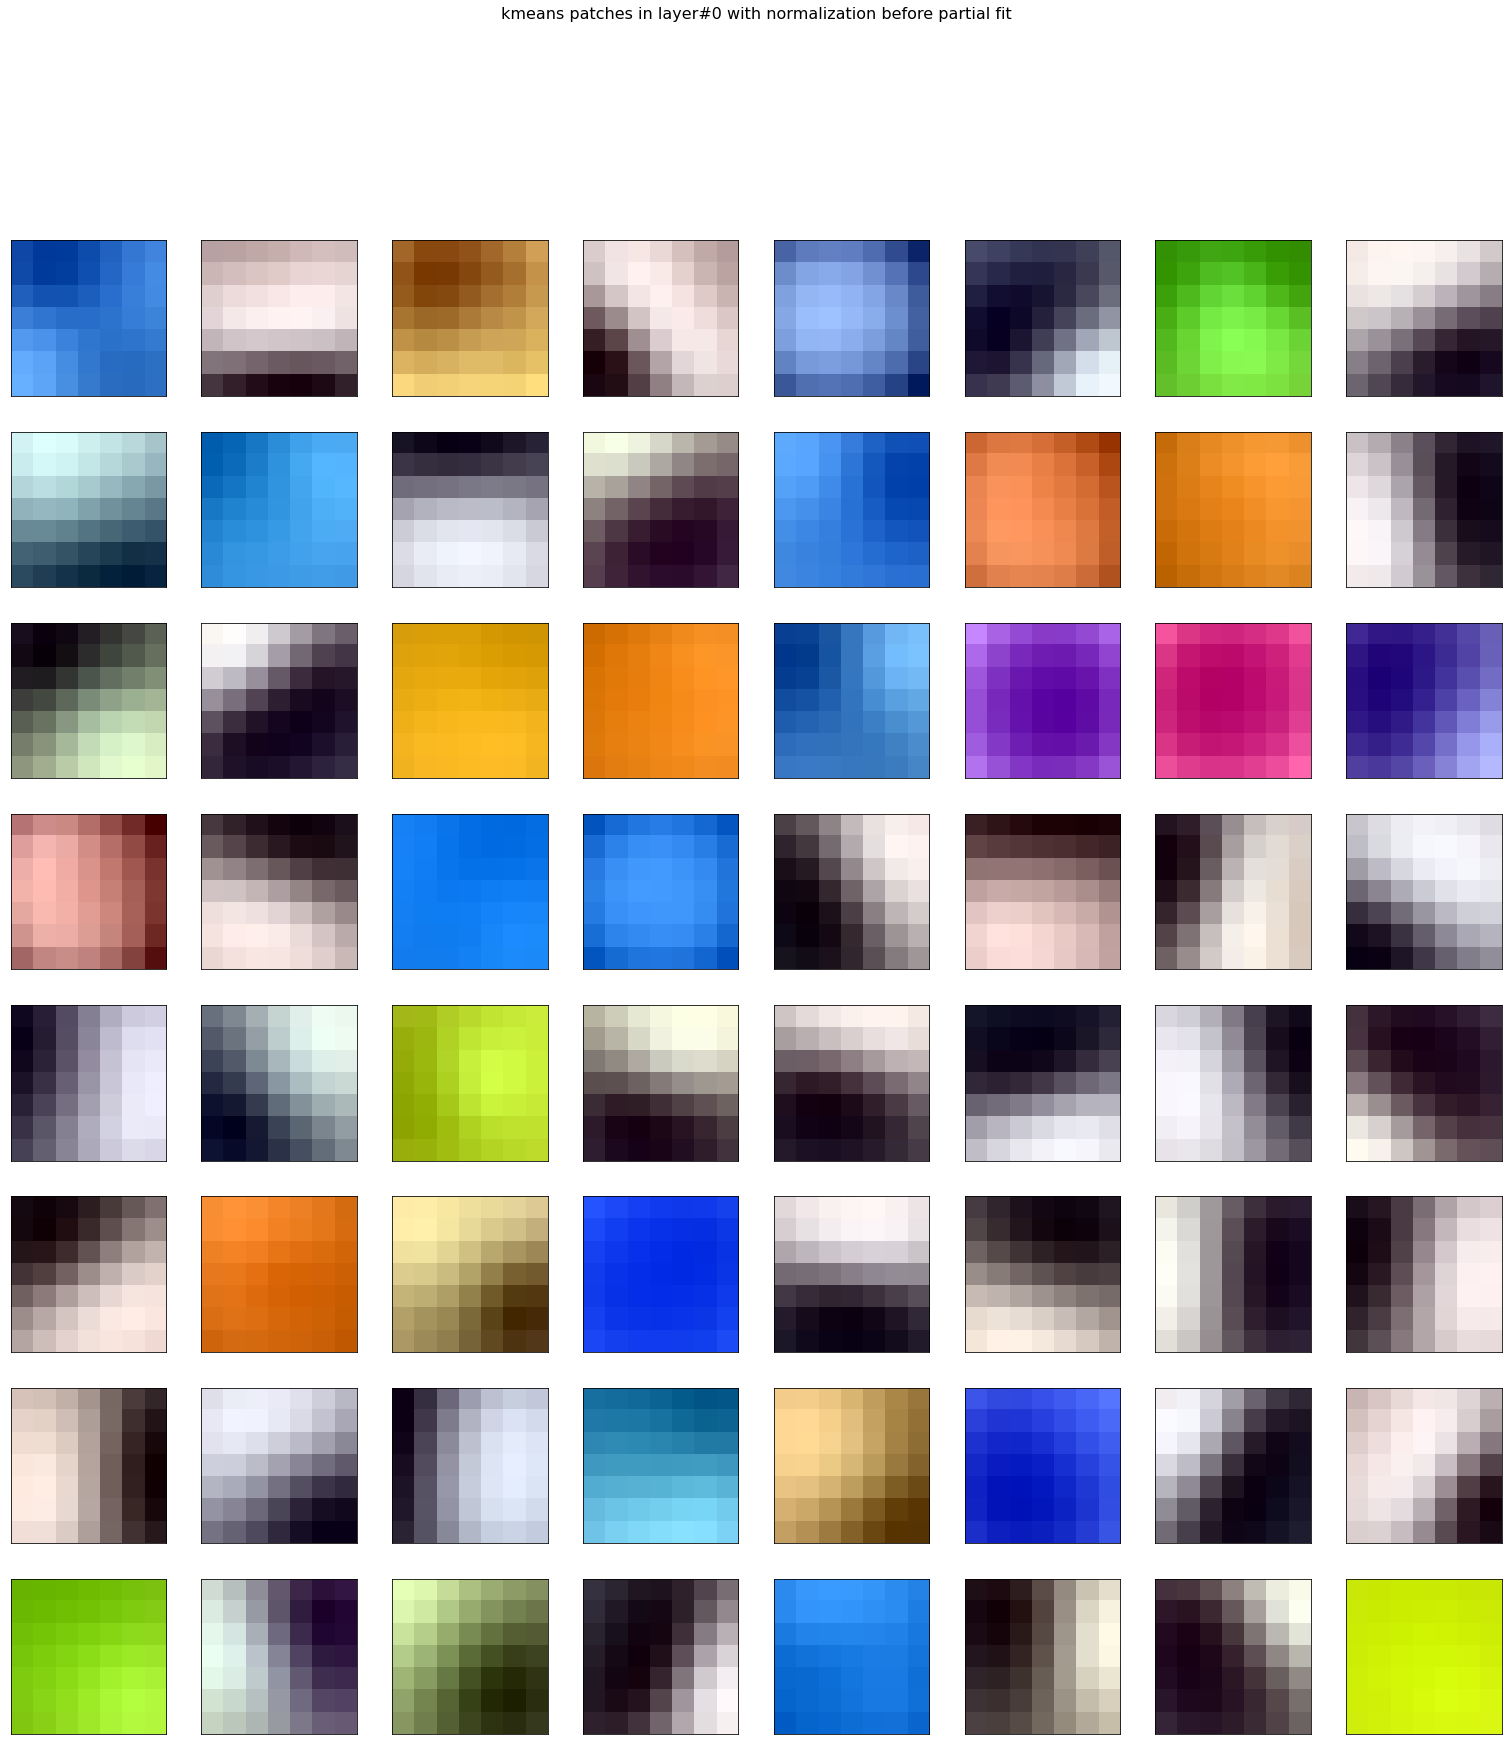

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))
for i, patch in enumerate(first_layer_weights):
    plt.subplot(8, 8, i + 1)
    img = patch.numpy() #.reshape(3, 7, 7) #patch_size[0], patch_size[1]
    img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
    img = np.clip(img, 0, 1)
    i,j,k = img.shape
    img = img.transpose((1,2,0))

    plt.imshow(img)
    plt.xticks(())
    plt.yticks(())

plt.suptitle("kmeans patches in layer#0 with normalization before partial fit", fontsize=16,)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'patches_0_layer_weights_no_norm.png')

In [20]:
from torchvision import utils
import torch
import matplotlib.pyplot as plt

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    print(rows)
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

9


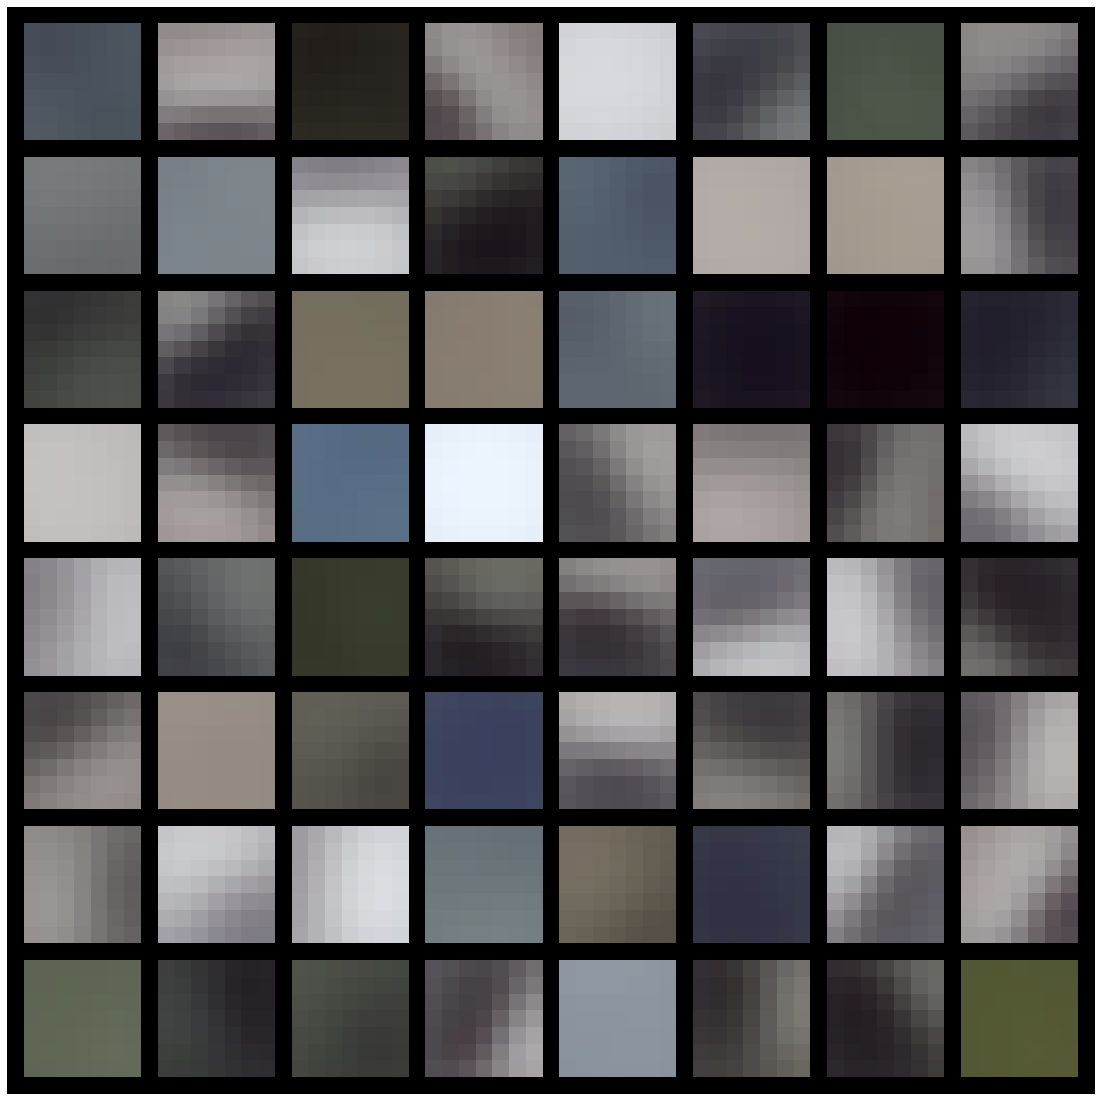

In [21]:
first_layer_weights = model[0].weight.data
visTensor(first_layer_weights, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
# plt.rcParams['savefig.facecolor']='white'
# plt.savefig(f'../images/mosaik_conv1_{kernel_size}_{mode}_filter_color.png')
plt.show()

# Check the patches of the 2nd layer

In [22]:
len(all_patches)

24048

In [23]:
layer_patches = all_patches[0:int(len(all_patches)/2)]
len(layer_patches)

12024

In [24]:
layer_patches[0].shape

(32, 147)

In [25]:
def visualize_3d_patches(patch):

    plt.figure(figsize=(25, 25))
    for i, patch in enumerate(patch):
        plt.subplot(8, 8, i + 1)
        img = patch.reshape(7, 7, 3) #patch_size[0], patch_size[1]
        img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.xticks(())
        plt.yticks(())

    # plt.suptitle("kmeans patches in layer#0 with normalization before partial fit", fontsize=16,)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

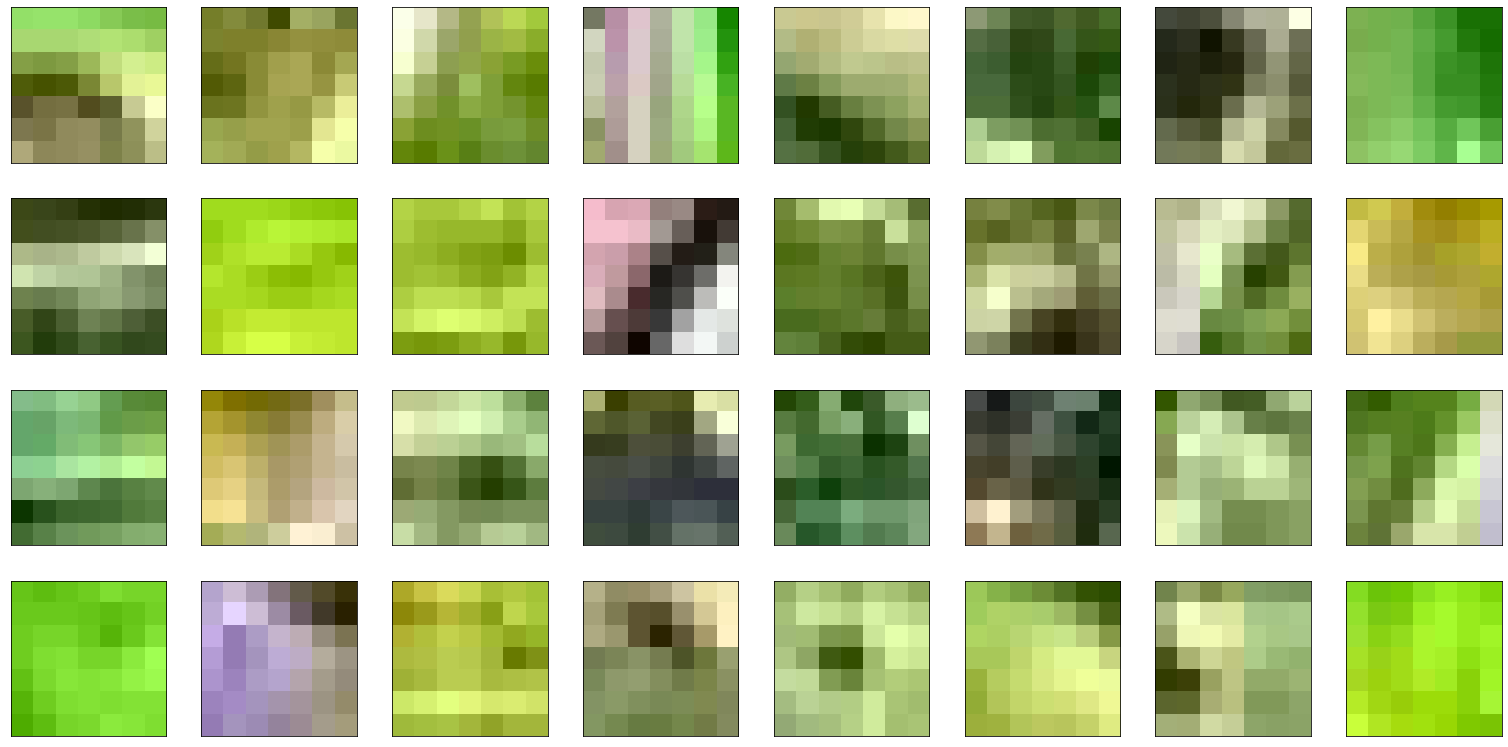

In [26]:
visualize_3d_patches(layer_patches[0])

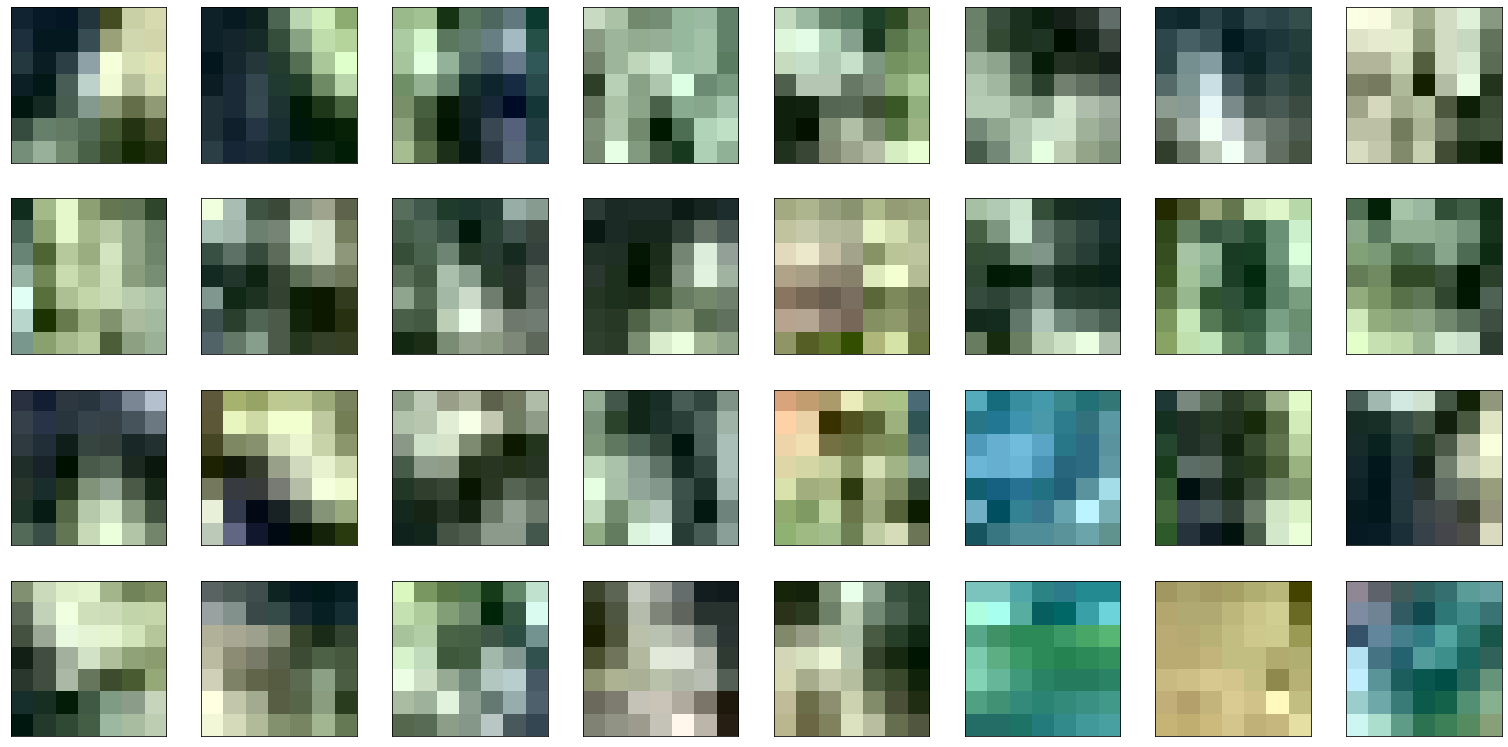

In [27]:
visualize_3d_patches(layer_patches[1])

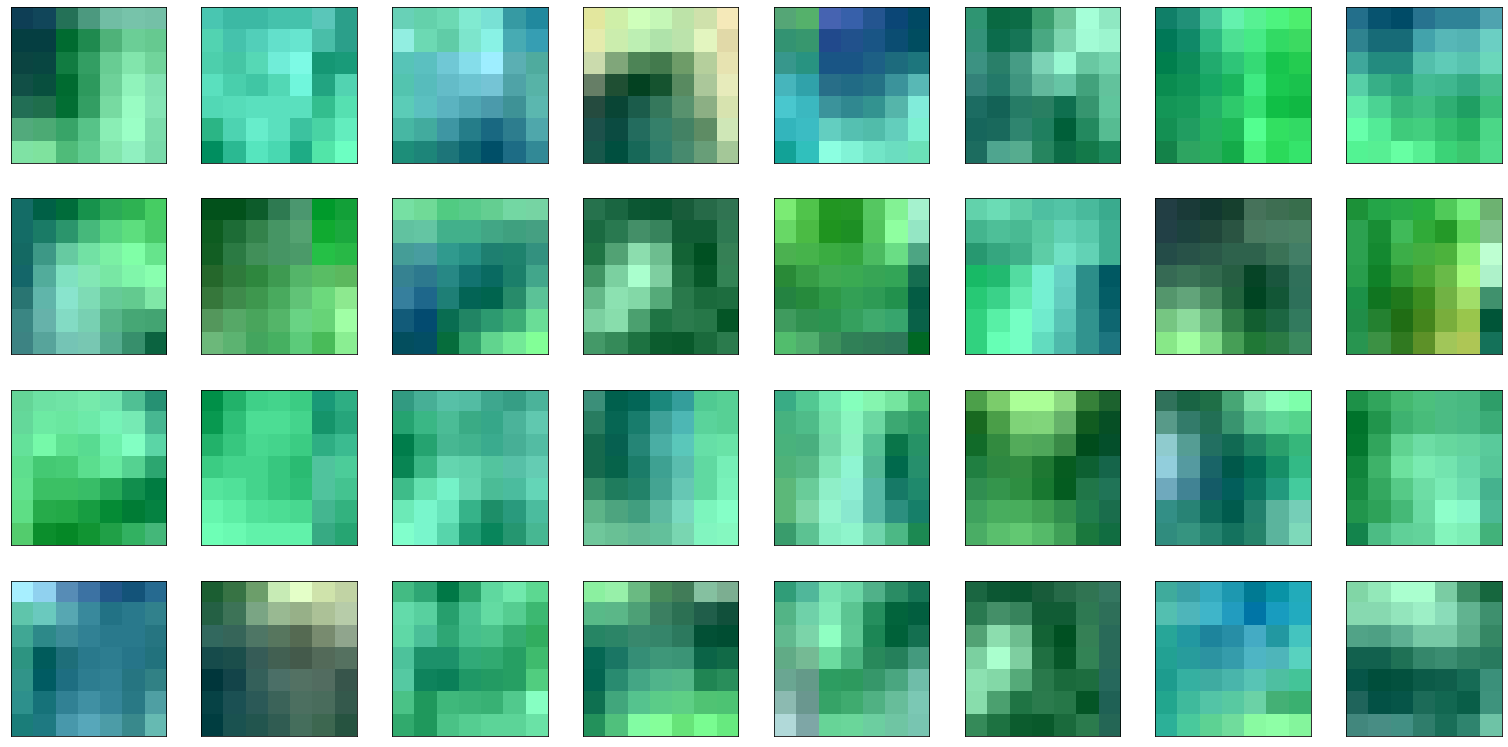

In [28]:
visualize_3d_patches(layer_patches[2])

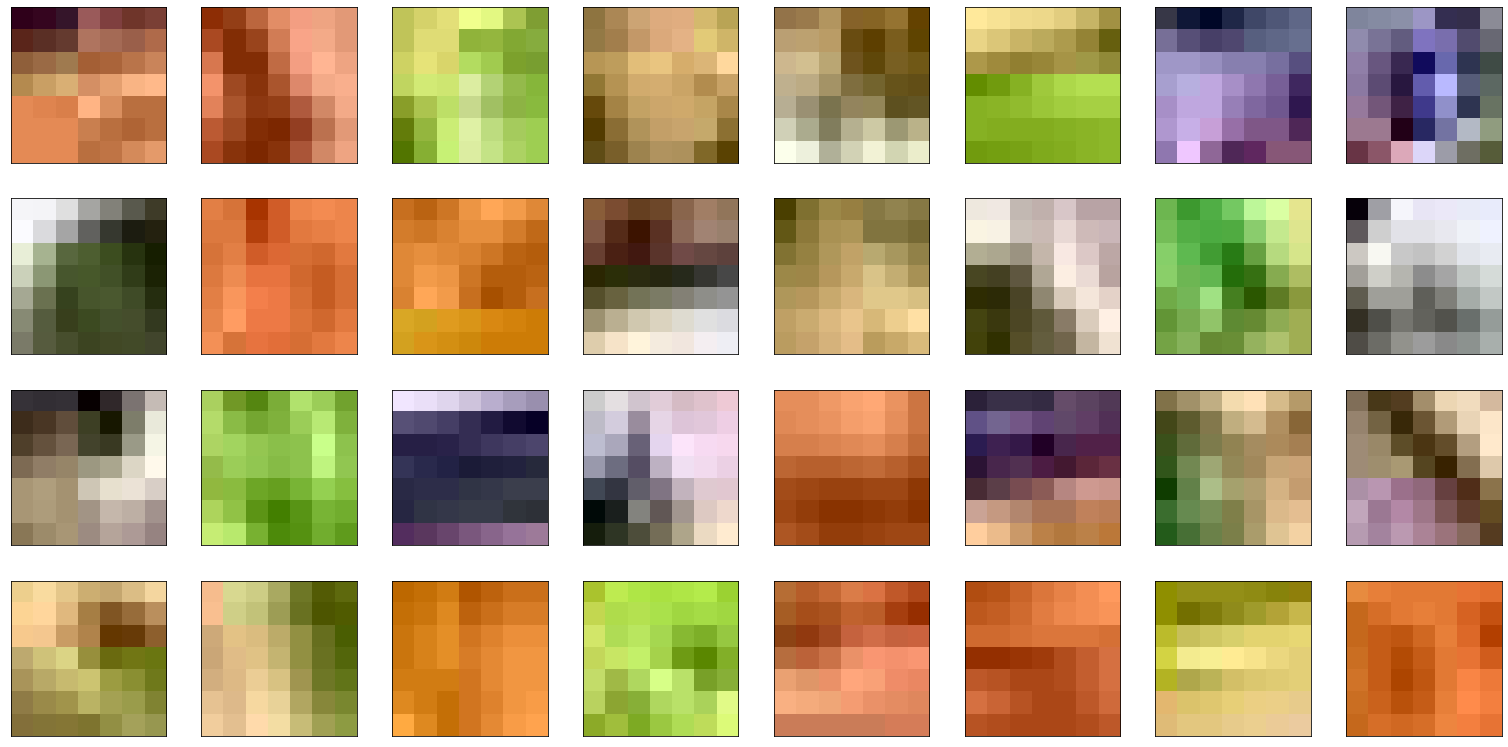

In [29]:
visualize_3d_patches(layer_patches[3])

In [30]:
tmp = np.array([[1,2,3,4], [2,4,5,7]])
print(tmp.shape)
print(tmp)
stds = np.std(tmp, axis=0)
print(stds.shape)
print(stds)

(2, 4)
[[1 2 3 4]
 [2 4 5 7]]
(4,)
[0.5 1.  1.  1.5]


In [31]:
layer_patches[0].shape

(32, 147)